In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('../')
from python_code import model
os.chdir('notebooks')
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import multivariate_normal
from tqdm import tqdm

In [2]:
df = pd.read_csv('../../data/cheese.csv')

In [3]:
group = df.groupby('store')
stores = list(group.groups.keys())

In [4]:
X_stores = []
y_stores = []
for store in stores:
    df_store = group.get_group(store)
    X = np.ones([df_store.shape[0], 4])
    X[:, 1] = np.log(df_store['price'])
    X[:, 2] = df_store['disp'] 
    X[:, 3] = df_store['disp'] * np.log(df_store['price'])
    y = np.log(df_store['vol']).to_numpy()
    X_stores.append(X)
    y_stores.append(y)

In [5]:
mod = model.Model(X_stores, y_stores, df.shape[0], n_iter=5000)
mod.fit()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 130.22it/s]


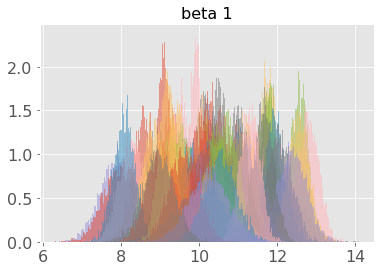

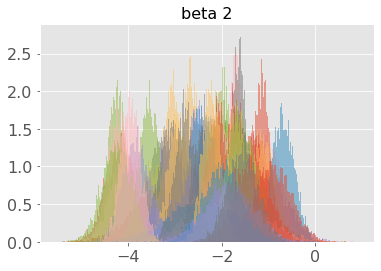

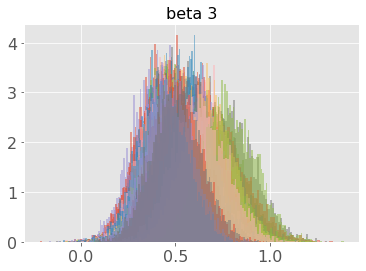

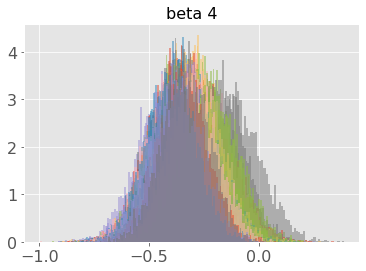

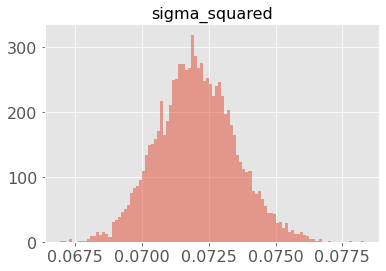

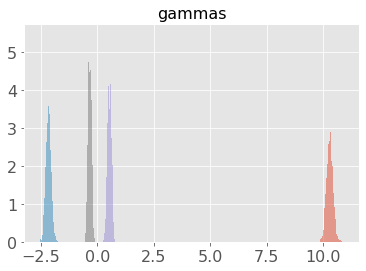

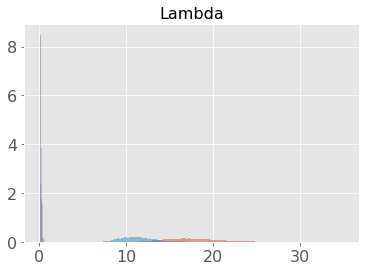

<Figure size 432x288 with 0 Axes>

In [7]:
mod.plot_all_histograms()

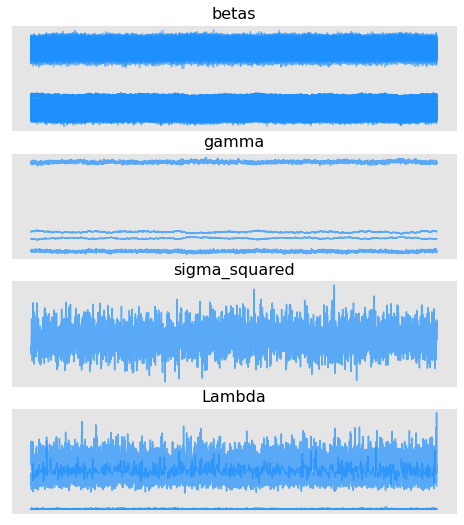

In [8]:
mod.plot_all_traces()

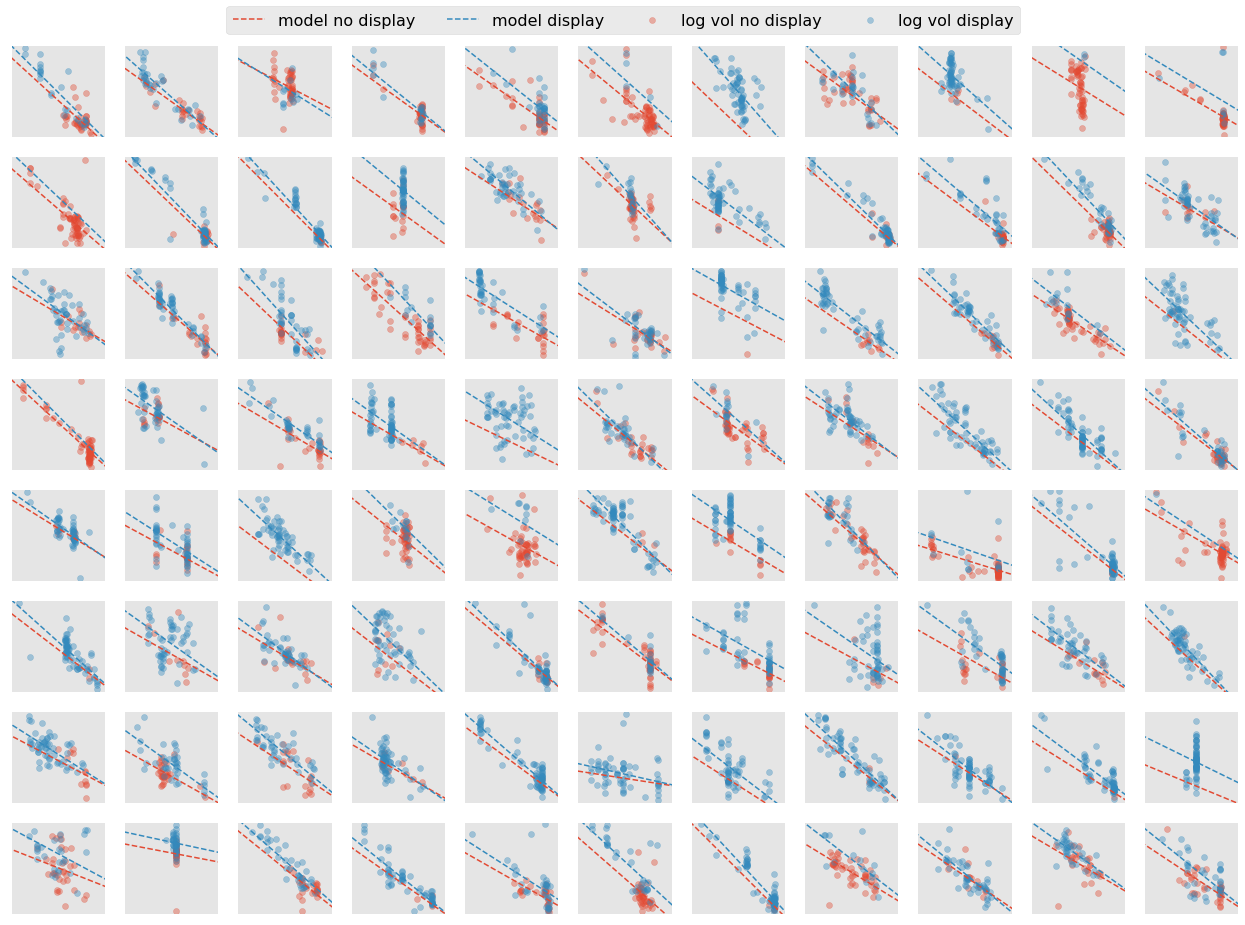

In [9]:
plt.figure(figsize=(22, 16))

for i in range(len(stores)):
    plt.subplot(8, 11, i+1)
    disp = X_stores[i][:, 2]
    plt.xticks([])
    plt.yticks([])
    plt.scatter(X_stores[i][disp == 0][:, 1], y_stores[i][disp == 0], alpha = .4, label='log vol no display')
    plt.scatter(X_stores[i][disp == 1][:, 1], y_stores[i][disp == 1], alpha = .4, label='log vol display') 
    
    betas = mod.traces['betas'].mean(axis=0)[:,i]
    X_plot = np.linspace(0,20,100)
    y_no_disp = X_plot*betas[1] + betas[0]
    y_disp = X_plot*(betas[1]+betas[3]) + betas[0] + betas[2]
    
    plt.plot(X_plot, y_no_disp, linestyle='--', label='model no display')
    plt.plot(X_plot, y_disp, linestyle='--', label='model display')
    plt.xlim(X_stores[i][:, 1].min() - 0.1 , X_stores[i][:, 1].max() + 0.1)
    plt.ylim(y_stores[i].min() - 0.1 , y_stores[i].max() + 0.1)
    if i == 0:
        plt.legend(bbox_to_anchor=(2.2,1.5),ncol=4)
plt.savefig('cheese.png',dpi=800)    

In [167]:
n_traces = 100
stores_sim_data = []
n_stores = len(stores)

for store in tqdm(range(n_stores)):
    n_points = len(X_stores[store])
    y_simulated = np.zeros([n_traces, n_points])
    for trace in range(n_traces):
        betas = mod.traces['betas'][trace,:,store]
        cov = np.identity(n_points) * mod.traces['sigma_squared'][trace]
        y_i = multivariate_normal(mean=X_stores[store]@betas, cov=cov ).rvs()
        y_simulated[trace, :] = y_i
    
    stores_sim_data.append(y_simulated)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:08<00:00,  9.82it/s]


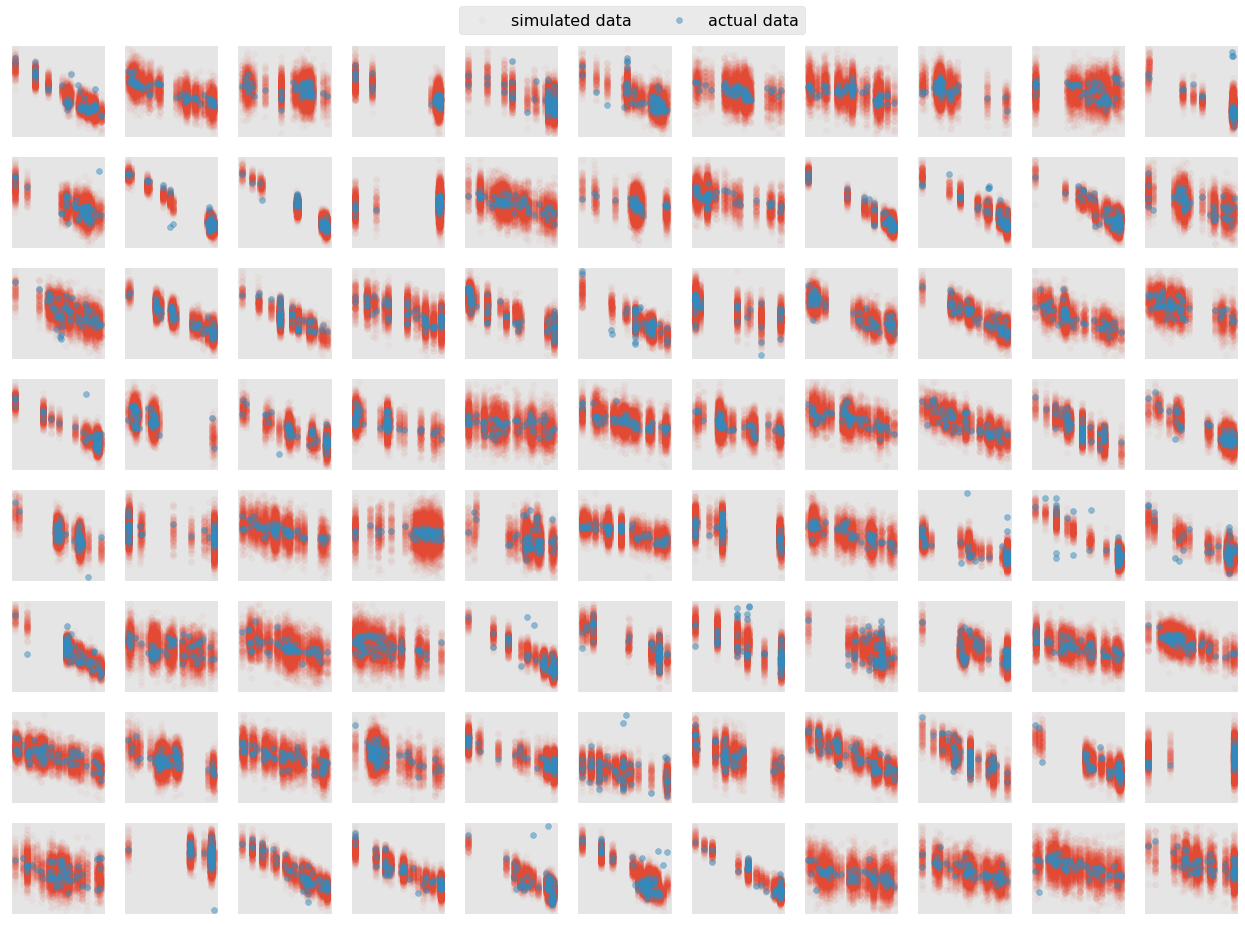

In [171]:
plt.figure(figsize=(22, 16))
for store in range(n_stores):
    plt.subplot(8, 11, store+1)
    n_points = len(X_stores[store])
    plt.scatter(np.repeat(X_stores[store][:,1], n_traces).reshape(n_points,n_traces),  stores_sim_data[store].T, alpha=.04, label='simulated data')
    plt.scatter(X_stores[store][:, 1], y_stores[store], alpha=.5, label='actual data')
    plt.xticks([])
    plt.yticks([])
    if store == 0:
        plt.legend(bbox_to_anchor=(8.5,1.5),ncol=2)

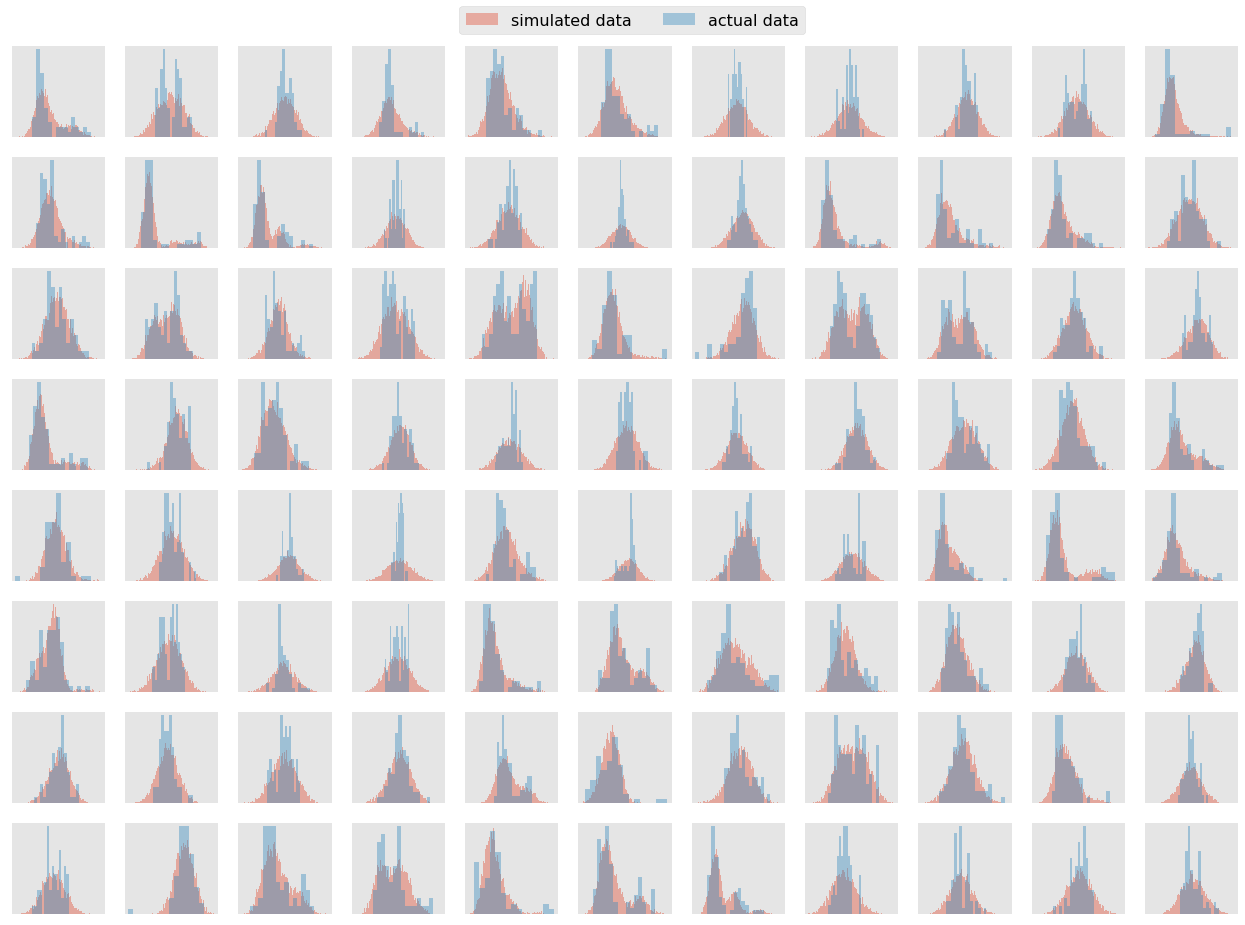

In [169]:
plt.figure(figsize=(22, 16))
for store in range(n_stores):
    plt.subplot(8, 11, store+1)
    n_points = len(X_stores[store])
    plt.hist(stores_sim_data[store].flatten(), alpha=.4, label='simulated data', density=True, bins=100)
    plt.hist(y_stores[store], alpha=.4, label='actual data', density=True, bins=15)
    plt.xticks([])
    plt.yticks([])
    if store == 0:
        plt.legend(bbox_to_anchor=(8.5,1.5),ncol=2)